<a href="https://colab.research.google.com/github/yashnarkhede/43_Scrum-Lordz_3/blob/main/Prediction_of_on_time_delivery_of_products.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of on time delivery of products

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder , StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency
from xgboost import XGBRegressor



In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/Ecommerce_Train.csv')
dataset.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


# Data Profiling

In [4]:
dataset.shape

(10999, 12)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [6]:
dataset.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

**Observations:**
* No missing values in the dataset

In [7]:
#Basic summary statistics
dataset.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


# Exploratory Data Analysis

In [8]:
dataset.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


([<matplotlib.patches.Wedge at 0x7fae57acb390>,
 [Text(0.32902377754583456, 1.0496396304491695, '0'),
  Text(-0.32902377754583423, -1.0496396304491697, '1')],
 [Text(0.17946751502500063, 0.5725307075177288, '40.33%'),
  Text(-0.17946751502500047, -0.5725307075177288, '59.67%')])

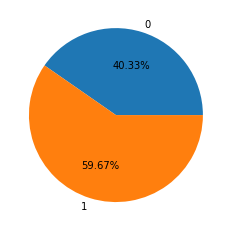

In [9]:
delay=pd.DataFrame(dataset.groupby(['Reached.on.Time_Y.N'])['ID'].count()/len(dataset)).reset_index()
plt.pie(delay['ID'],labels=delay['Reached.on.Time_Y.N'],autopct='%1.2f%%')

**Observations:**
* 40% of the total deliveries are not reached on time

In [10]:
data_v1 = dataset[dataset['Reached.on.Time_Y.N']==0]

Text(0, 0.5, 'percentage')

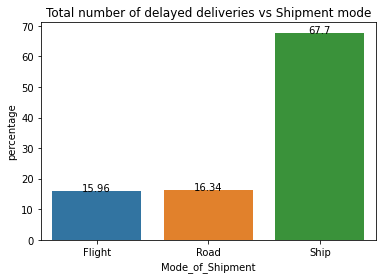

In [11]:
data_v2=pd.DataFrame((data_v1.groupby(['Mode_of_Shipment'])['ID'].count())/len(data_v1)*100)
data_v2=data_v2.reset_index()
visual=sns.barplot(x="Mode_of_Shipment", y="ID", data=data_v2 )
for index, row in data_v2.iterrows():
    visual.text(row.name,row.ID, round(row.ID,2), color='black', ha="center")
plt.title('Total number of delayed deliveries vs Shipment mode')
plt.ylabel('percentage')

**Observations:**
* Around 68% of the delayed deliveries are caused when ships are used as a mode of shipments. So, Alternate options like Flight and Road services might be considered to reduce the delayed deliveries 

Text(0, 0.5, 'percentage')

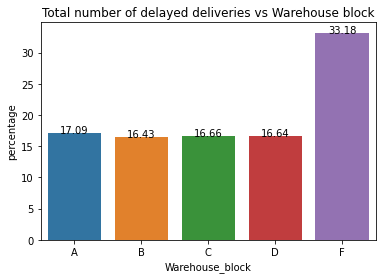

In [12]:
data_v3=pd.DataFrame((data_v1.groupby(['Warehouse_block'])['ID'].count())/len(data_v1)*100)
data_v3=data_v3.reset_index()
visual=sns.barplot(x="Warehouse_block", y="ID", data=data_v3 )
for index, row in data_v3.iterrows():
    visual.text(row.name,row.ID, round(row.ID,2), color='black', ha="center")
plt.title('Total number of delayed deliveries vs Warehouse block')
plt.ylabel('percentage')

**Observations**
* Higher percent of delayed deliveries are recorded in Warehouse block F. For rest of the block,the percent of delayed deliveries are almost consistent

Text(0, 0.5, 'percentage')

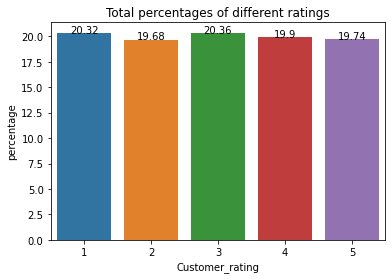

In [13]:
data_v4=pd.DataFrame((dataset.groupby(['Customer_rating'])['ID'].count())/len(dataset)*100)
data_v4=data_v4.reset_index()
visual=sns.barplot(x="Customer_rating", y="ID", data=data_v4 )
for index, row in data_v4.iterrows():
    visual.text(row.name,row.ID, round(row.ID,2), color='black', ha="center")
plt.title('Total percentages of different ratings')
plt.ylabel('percentage')

**Observations:**
* The percentage of different ratings given by customers seems to same. Almost 20% of the total deliveries received 5 ratings

Text(0.5, 1.0, 'Product importance by Reached on Time or Not')

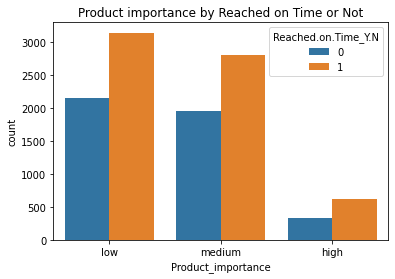

In [14]:
sns.countplot(x = "Product_importance", data = dataset, hue="Reached.on.Time_Y.N")
plt.title("Product importance by Reached on Time or Not")

**Observations:**
* Higher number of deliveries falls under low product importance. Very less number of highly important products delivered. It means customers are ordering more number of low importance products from this ecommerce group

Text(0.5, 1.0, 'Gender by Reached on Time or Not')

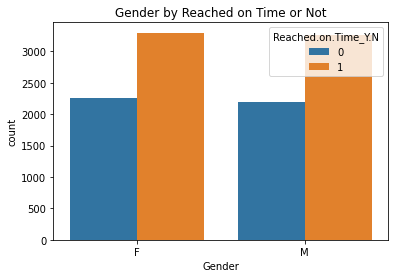

In [15]:
sns.countplot(x = "Gender", data = dataset, hue="Reached.on.Time_Y.N")
plt.title("Gender by Reached on Time or Not")

Text(0.5, 1.0, 'Warehouse block vs on Time or Not')

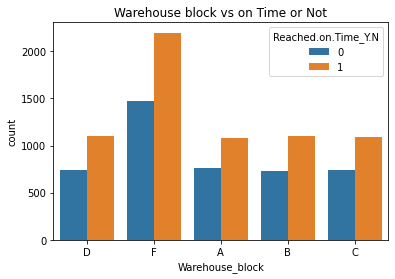

In [16]:
sns.countplot(x = "Warehouse_block", data = dataset, hue="Reached.on.Time_Y.N")
plt.title("Warehouse block vs on Time or Not")

**Observations:**
* More number of deliveries were from Ware house block 'F'
* For rest of the blocks, the pattern remains same

Text(0.5, 1.0, 'Customer ratings by Gender')

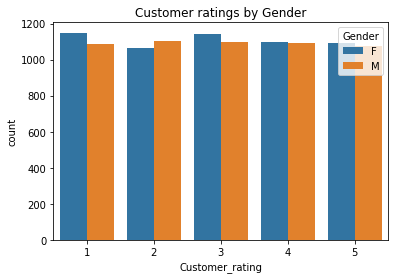

In [17]:
sns.countplot(x = "Customer_rating", data = dataset, hue="Gender")
plt.title("Customer ratings by Gender")

Text(0.5, 1.0, 'Amount spent by each Gender')

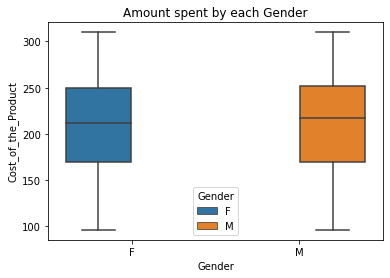

In [18]:
sns.boxplot(x='Gender',y='Cost_of_the_Product',data=dataset,hue='Gender')
plt.title("Amount spent by each Gender")

**Observations**
* Both men and women seems to spend same level of amount on average while purchasing a product 

Text(0.5, 1.0, 'Average cost of products of different importance')

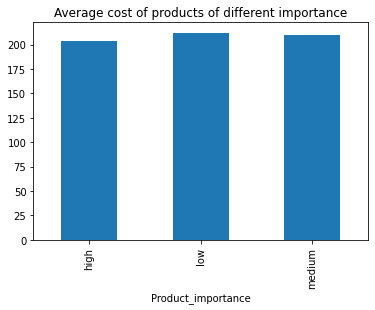

In [19]:
dataset.groupby(['Product_importance'])['Cost_of_the_Product'].mean().plot.bar()
plt.title("Average cost of products of different importance")

**Observations:**
* The average value of higher importance is slightly lesser than both low and high importance products. So, the product importance is not assigned based on the monetory value
* Overall there isnt much variation in the features

In [20]:
dataset.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae571753d0>,
      dtype=object)

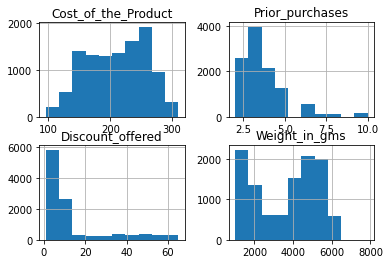

In [21]:
dataset[['Cost_of_the_Product','Prior_purchases','Discount_offered','Weight_in_gms']].hist()


**Observations**
* 'Discount_offered' is positively skewed
* Even 'prior purchase' is also positively skewed

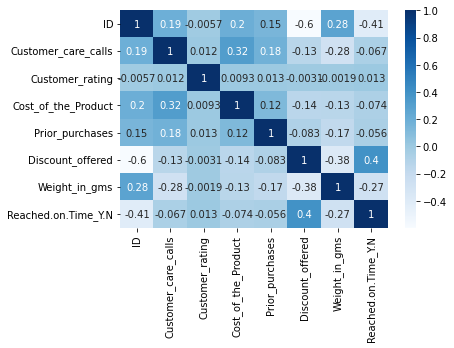

In [22]:
corr = dataset.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

**Observations:**
*  There is a slight positive correlation between 'cost of products' and 'customer care calls'

# Data preparation

In [23]:
#Dropping the ID column because of high cardinality
data=dataset.drop(['ID'],axis=1)
data.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1
3,B,Flight,3,3,176,4,medium,M,10,1177,1
4,C,Flight,2,2,184,3,medium,F,46,2484,1


**Chi square test of independence**

In [24]:
#Warehouse_block
crossTab = pd.crosstab(data['Warehouse_block'], data['Reached.on.Time_Y.N'])
ChiSqResult = chi2_contingency(crossTab)
print("p-value ",ChiSqResult[1])

p-value  0.8959524278243698


In [25]:
#Warehouse_block
crossTab = pd.crosstab(data['Mode_of_Shipment'],data['Reached.on.Time_Y.N'])
ChiSqResult = chi2_contingency(crossTab)
print("p-value ",ChiSqResult[1])

p-value  0.6895487627593786


In [26]:
# Product_importance
crossTab = pd.crosstab(data['Product_importance'],data['Reached.on.Time_Y.N'])
ChiSqResult = chi2_contingency(crossTab)
print("p-value ",ChiSqResult[1])

p-value  0.002230383104745087


In [27]:
# Gender
crossTab = pd.crosstab(data['Gender'],data['Reached.on.Time_Y.N'])
ChiSqResult = chi2_contingency(crossTab)
print("p-value ",ChiSqResult[1])

p-value  0.6367032124181522


**Observations:**
* From chi square test, we can conclude that three of the independent categorical features are not related to the response variable beacause the p value is greater than 0.05. So, these features can be removed and only product importance feature can be included

In [28]:
#Renaming the column Reached.on.Time_Y.N
data.rename(columns={'Reached.on.Time_Y.N':'Reached on Time'}, inplace=True)

In [29]:
data=pd.get_dummies(data,columns=['Product_importance'], drop_first=True)
data.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Gender,Discount_offered,Weight_in_gms,Reached on Time,Product_importance_low,Product_importance_medium
0,D,Flight,4,2,177,3,F,44,1233,1,1,0
1,F,Flight,4,5,216,2,M,59,3088,1,1,0
2,A,Flight,2,2,183,4,M,48,3374,1,1,0
3,B,Flight,3,3,176,4,M,10,1177,1,0,1
4,C,Flight,2,2,184,3,F,46,2484,1,0,1


In [30]:
X=data.drop(['Reached on Time','Warehouse_block','Mode_of_Shipment','Gender'],axis=1)
y=data['Reached on Time']

In [ ]:
features=data_sales.drop(columns=['Reached on Time','Warehouse_block','Mode_of_Shipment','Gender' ])
target=data_sales['Reached on Time']

NameError: ignored

In [31]:
#Splitting data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

#Scaling the data
ms = MinMaxScaler()
X_train = ms.fit_transform(X_train)
X_test = ms.fit_transform(X_test)

In [32]:
X_train = pd.DataFrame(X_train,columns=X.columns)
X_test  =pd.DataFrame(X_test,columns=X.columns)
X_train.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Product_importance_low,Product_importance_medium
0,0.2,1.0,0.383178,0.125,0.093750,0.457852,1.0,0.0
1,0.8,0.5,0.495327,0.250,0.031250,0.510592,0.0,1.0
2,0.0,1.0,0.845794,0.125,0.078125,0.004529,0.0,1.0
3,0.6,1.0,0.574766,0.000,0.046875,0.480351,0.0,1.0
4,0.8,0.5,0.934579,0.250,0.046875,0.094814,1.0,0.0


**Support Vector Machine**

In [33]:
svm_model = svm.SVC(gamma='auto',C=5,kernel='rbf')
svm_model.fit(X_train,y_train)
y_pred = svm_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.55      0.85      0.67       895
           1       0.83      0.53      0.65      1305

    accuracy                           0.66      2200
   macro avg       0.69      0.69      0.66      2200
weighted avg       0.72      0.66      0.66      2200



**Random Forest Classifier**

In [34]:
params = {'n_estimators':[100,150], 'criterion':['gini', 'entropy']}
#Hyper parameter tuning
rf_model =GridSearchCV(estimator=RandomForestClassifier(),param_grid=params,scoring='accuracy', cv=5)
rf_model = rf_model.fit(X_train,y_train)
y_pred=rf_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.58      0.66      0.62       895
           1       0.74      0.67      0.71      1305

    accuracy                           0.67      2200
   macro avg       0.66      0.66      0.66      2200
weighted avg       0.68      0.67      0.67      2200



**XGBOOST**

In [35]:
xgbr = xgb.XGBRegressor(verbosity=0) 
print(xgbr)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)
xgbr.fit(X_train, y_train)
score = xgbr.score(X_train, y_train)  
print("Training score: ", score)

XGBRegressor(verbosity=0)
Training score:  0.29123077585289303


**Artificial Neural Network**

In [36]:
ann = Sequential()
ann.add(Dense(14,input_dim=8,activation='relu'))
ann.add(Dense(8,activation='relu'))
ann.add(Dense(8,activation='relu'))
ann.add(Dense(8,activation='relu'))
ann.add(Dense(1,activation='sigmoid'))
ann.compile(loss="binary_crossentropy", optimizer='Adam',metrics=['accuracy'])
ann.fit(X_train, y_train, epochs=100, batch_size=15)

Epoch 1/100
587/587 [==============================] - 5s 3ms/step - loss: 0.5847 - accuracy: 0.6246
Epoch 2/100
587/587 [==============================] - 2s 3ms/step - loss: 0.5281 - accuracy: 0.6550
Epoch 3/100
587/587 [==============================] - 2s 3ms/step - loss: 0.5244 - accuracy: 0.6644
Epoch 4/100
587/587 [==============================] - 2s 3ms/step - loss: 0.5224 - accuracy: 0.6606
Epoch 5/100
587/587 [==============================] - 2s 3ms/step - loss: 0.5202 - accuracy: 0.6593
Epoch 6/100
587/587 [==============================] - 2s 3ms/step - loss: 0.5185 - accuracy: 0.6636
Epoch 7/100
587/587 [==============================] - 2s 3ms/step - loss: 0.5170 - accuracy: 0.6706
Epoch 8/100
587/587 [==============================] - 2s 3ms/step - loss: 0.5153 - accuracy: 0.6720
Epoch 9/100
587/587 [==============================] - 2s 3ms/step - loss: 0.5148 - accuracy: 0.6735
Epoch 10/100
587/587 [==============================] - 2s 3ms/step - loss: 0.5140 - accura

In [37]:
predictions = (ann.predict(X_test) > 0.5)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.57      0.89      0.69       895
           1       0.87      0.53      0.66      1305

    accuracy                           0.68      2200
   macro avg       0.72      0.71      0.68      2200
weighted avg       0.75      0.68      0.67      2200



**Conclusion:**
* ANN gives better accuracy of 68% than SVM and Random forest

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression, RANSACRegressor, Lasso, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [39]:
lr_pipeline = Pipeline([("scaler", StandardScaler()), ("linear_regression", LinearRegression())])
ridge_pipeline = Pipeline([("scaler", StandardScaler()), ("ridge_regressor", Ridge(random_state = 42))])
lasso_pipeline = Pipeline([("scaler", StandardScaler()), ("lasso_regressor", Lasso(random_state = 42))])
random_forest_pipeline = Pipeline([("scaler", StandardScaler()), ("randomforest_regression", RandomForestRegressor(random_state = 42))])
xgboost_pipeline = Pipeline([("scaler", StandardScaler()), ("xgboost_regression", XGBRegressor())])
knn_pipeline = Pipeline([("scaler", StandardScaler()), ("knn_regression", KNeighborsRegressor())])

In [40]:
pipelines = [lr_pipeline, ridge_pipeline, lasso_pipeline,
            random_forest_pipeline, xgboost_pipeline, knn_pipeline]

pipe_dict = {0: "Linear Regression", 1: "Ridge",
            2: "Lasso", 3: "RandomForest", 4: "XGBoost",
            5: "Decision Tree", 6: "KNN"}